In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("drama_final.csv")

In [2]:
df.groupby('genre').count()

,Unnamed: 0,review
genre,,
crime,4580,4580
drama,1558,1558
fantasySF,2136,2136
roco,4606,4606
thriller,10069,10069


In [3]:
thriller = df[df['genre']=='thriller'].review.to_list()
sentence = ",".join(thriller)

# 필요 함수들

In [ ]:
pip install contextualized_topic_models

In [4]:
import re
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
# from contextualized_topic_models.models.ctm import CombinedTM
# from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation, bert_embeddings_from_list
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from konlpy.tag import Okt
from tqdm import tqdm

In [5]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('V'):
        return 'v'
    elif pos_tag.startswith('N'):
        return 'n'
    elif pos_tag.startswith('J'):
        return 'a'
    elif pos_tag.startswith('R'):
        return 'r'
    else:
        return None

In [6]:
from nltk.corpus import stopwords
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
stop_words.update(('\r', '\n', '\r\n', '\n\r'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\g8428\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\g8428\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\g8428\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\g8428\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
class CustomTokenizer:
    def __init__(self, tagger):
        self.tagger = tagger
    def __call__(self, a):
        a = ''.join(a)
        word_tokens = self.tagger(a)
        
        words = []

        for i in word_tokens:
            text = re.sub('[^a-zA-Z0-9\']','',i).strip()
            text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`…》]','', text)
            if(text != ''):
                words.append(text)
        
        tag_words = nltk.pos_tag(words)
        pos_words = [word for word in tag_words if word[1][0] in {'V','N','J','R'}]

        temp_list = []
        for token, pos_tag in pos_words:
            tag = get_wordnet_pos(pos_tag)
            if tag != None:
                temp_list.append((token, get_wordnet_pos(pos_tag)))
        lemma = WordNetLemmatizer()
        token_final = [lemma.lemmatize(token, pos=tag) for token, tag in temp_list]
        long_words = [i for i in token_final if len(i) > 2]
        results = [w for w in long_words if w not in stop_words]
        return results

# 작업

In [8]:
ngram_range = (2,3)
stop_words = set(stopwords.words('english'))
stop_words.update(('\r', '\n', '\r\n', '\n\r'))

custom_tokenizer = CustomTokenizer(text_to_word_sequence)
custom_tokenizer(sentence)

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,ngram_range = ngram_range, stop_words=stop_words,
                        max_df=10, min_df=2,max_features=10000).fit(thriller)
candidates = tfidf.get_feature_names()

C:\Users\g8428\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
C:\Users\g8428\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  % sorted(inconsistent)
C:\Users\g8428\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
len(candidates)

10000

# 임베딩

In [25]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
# doc_embedding = model.encode([sentence])
doc_embedding = model.encode(thriller)
candidate_embeddings = model.encode(candidates)

In [27]:
candidate_embeddings.shape, doc_embedding.shape

((10000, 768), (10069, 768))

# 코사인 유사도 연구(건너뛰어도 됨)

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

top_n = len(candidates)

# 문서와 키워드간 유사도
distances = cosine_similarity(candidate_embeddings,doc_embedding)

# 키워드와 키워드간 유사도
distances_candidates = cosine_similarity(candidate_embeddings)

In [31]:
distances.shape, distances_candidates.shape, len(candidates) # candidates[index]

((10000, 10069), (10000, 10000), 10000)

In [32]:
word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
word_distances = cosine_similarity(candidate_embeddings)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
top_n = 1000
diversity = 0.7

def nonmmr(doc_embedding, candidate_embeddings, words, top_n, diversity):
    word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
    word_distances = cosine_similarity(candidate_embeddings) 

    keywords_idx = [np.argmax(word_doc_distances)]
    candidates_idx = [i for i in range(len(candidates)) if i != keywords_idx[0]]

    for _ in range(top_n-1):
        # 후보 키워드들의 문서유사도 값
        candidate_similarities = word_doc_distances[candidates_idx, :]
        # 후보 키워드와 가장 유사한 키워드
        target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1) 

        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)
    # 본 단어 임베딩벡터에서 추출키워드에 해당하는 벡터만
    keywords_vector = candidate_embeddings[keywords_idx][:] 
    keywords = [words[idx] for idx in keywords_idx]
    
    return keywords_vector, keywords

In [133]:
keywords_idx = [7,87,92]
candidates_idx = [1,2,13,734,25,6]
candidate_similarities = word_doc_distances[candidates_idx, :]
candidate_similarities, candidate_similarities.shape # 후보키워드의 문서간유사도 벡터

(array([[-0.00580319],
        [-0.19800502],
        [-0.01558762],
        [-0.04957973],
        [ 0.0070086 ],
        [-0.16266811]], dtype=float32),
 (6, 1))

In [84]:
word_distances[candidates_idx][:,keywords_idx] # 후보키워드와 추출키워드의 유사도 벡터

array([[ 3.2524187e-02,  5.1560111e-02,  2.2039059e-01,  1.3396120e-01,
        -1.4120573e-04],
       [ 1.7449439e-01,  2.5826111e-01,  7.1534671e-02,  4.0343547e-01,
         3.3822396e-01],
       [ 1.4734800e-01,  1.9027355e-01,  2.1794148e-02,  3.4675038e-01,
         3.8210323e-01],
       [ 8.3954439e-02,  1.4057627e-01,  9.0675689e-02,  2.7277958e-01,
         3.1519559e-01]], dtype=float32)

In [ ]:
 target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1)
 target_similarities, target_similarities.shape # 후보키워드와 가장 유사한 추출 키워드 벡터

(array([0.30213898, 0.0680101 , 0.21618617], dtype=float32), (3,))

In [ ]:
mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
mmr,mmr.shape # mmr 계산을 통해 후보키워드에서 추출할 키워드 선정

(array([[-0.23494704],
        [-0.00761976],
        [-0.15552332]], dtype=float32), (3, 1))

In [149]:
for i in np.argsort(word_distances[candidates_idx][:,7])[:4]:
    print(candidates[i])

'lunar
'letting
'hotel
'letting go' 'unselfish


In [150]:
similar_keys = []
for i in keywords_idx:
    temp = []
    for j in np.argsort(word_distances[candidates_idx][:,i])[:4]:
        temp.append(candidates[j])
    similar_keys.append(temp)

In [151]:
similar_keys = []
for i in keywords_idx:
    temp = []
    for j in np.argsort(word_distances[candidates_idx][:,i])[:4]:
        temp.append(candidates[j])
    similar_keys.append(temp)
for i, keys in enumerate(keywords_idx):
    print(f'{candidates[keys]} : {similar_keys[i]}')


'lunar : ["'counters'", "'letting", "'letting go'", "'hotel"]
'lunar water' : ["'counters'", "'letting", "'letting go' 'unselfish", "'letting go'"]
'magical : ["'lunar", "'letting", "'hotel", "'letting go' 'unselfish"]


In [146]:
keywords_idx = [5,6,7]
word_distances[candidates_idx][:,keywords_idx]
np.sort(word_distances[candidates_idx][:,keywords_idx],axis=1)[:][:2]

array([[ 0.03252419,  0.05156011,  0.22039059],
       [ 0.17449439,  0.2582611 ,  0.07153467],
       [ 0.03501092,  0.09409308, -0.03085524],
       [ 0.11034438,  0.10579221,  0.29284918],
       [ 0.21789196,  0.09518174,  0.07269609],
       [ 0.79727995,  0.9999997 , -0.0317032 ]], dtype=float32)

In [105]:
candidates[7]

"'magical"

# 유사키워드 포함 추출하기

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
def mmrs(doc_embedding, candidate_embeddings, words, top_n, diversity):
    word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
    word_distances = cosine_similarity(candidate_embeddings) 

    keywords_idx = [np.argmax(word_doc_distances)]
    candidates_idx = [i for i in range(len(candidates)) if i != keywords_idx[0]]

    for _ in range(top_n-1):
        # 후보 키워드들의 문서유사도 값
        candidate_similarities = word_doc_distances[candidates_idx, :]
        # 후보 키워드와 가장 유사한 키워드
        target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1) 

        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)
        
        # 추출키워드와 유사한 키워드 추가
    similar_keys = []
    for i in keywords_idx:
        temp = []
        for j in np.argsort(word_distances[candidates_idx][:,i])[:top_n]:
            temp.append(words[j])
        similar_keys.append(temp)

    # 본 단어 임베딩벡터에서 추출키워드에 해당하는 벡터만

    keywords = [words[idx] for idx in keywords_idx]
    
    return keywords, similar_keys

In [13]:
keywords, similar_keys = mmrs(doc_embedding,candidate_embeddings,candidates,top_n=6,diversity=0.7)

In [14]:
print('Keywords and similar keys by cosine similarity')
for i in range(len(keywords)):
    print(f'{keywords[i]} : {similar_keys[i]}')

Keywords and similar keys by cosine similarity
excitement never stop : ['korean drama uncanny', 'wait see happen', 'korean drama silent', 'choose sacrificial lamb', 'etc set', 'rushed unfinished']
english teacher : ['never fully', 'action adventure', 'rest time', 'whole watch', 'fight evil spirit', 'edge seat episode']
sort buffy vampire : ['course main', 'cuz want', 'dad child', 'mean make', 'mean damn', "i'm say drama"]
noodle catch evil : ['man prove powerful', 'look however', 'time pick', 'couple main sideline', 'return season', 'inhabitant realm exist']
comatose teenager mun : ['sweet see', 'sweet romance', 'game spain actually', 'sweet home', 'sweet time', 'fictional city jungin']
drama disappoint : ['future character', 'koo walk ethic', 'jump jang', 'future exchange', 'young hong pyo', 'somewhat similar']


# 코사인 유사도 함수

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
top_n = 1000
diversity = 0.7

def mmr(doc_embedding, candidate_embeddings, words, top_n, diversity):
    word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
    word_distances = cosine_similarity(candidate_embeddings) 

    keywords_idx = [np.argmax(word_doc_distances)]
    candidates_idx = [i for i in range(len(candidates)) if i != keywords_idx[0]]

    for _ in range(top_n-1):
        # 후보 키워드들의 문서유사도 값
        candidate_similarities = word_doc_distances[candidates_idx, :]
        # 후보 키워드와 가장 유사한 키워드
        target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1) 

        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)
    # 본 단어 임베딩벡터에서 추출키워드에 해당하는 벡터만
    keywords_vector = candidate_embeddings[keywords_idx][:] 
    keywords = [words[idx] for idx in keywords_idx]
    
    return keywords_vector, keywords


In [26]:
keywords_vector, keywords = mmr(doc_embedding,candidate_embeddings,candidates,top_n=500,diversity=0.6)

IndexError: index 220037 is out of bounds for axis 1 with size 10000

In [16]:
keywords_vector.shape

(500, 768)

In [119]:
keywords[:10]

['seo favorite',
 'fight scene make',
 'kdrama ive watch',
 'supernatural phenomenon',
 'disappoint drama',
 'father also',
 'power money',
 'prison playbook',
 'korean film making',
 'teach lot']

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

X = keywords_vector

true_k = 8
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X.T)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = keywords # = candidates
for i in range(true_k):
    print("["),
    for ind in order_centroids[i, :20]:
        print(f'"{terms[ind]}"', end=",")
    print("],\n")

Top terms per cluster:
[
"move building","else show","game organizer","cast think","craft show","office late night","plot character development","dimensional character","live action adaptation","multiple episode","episode hour long","pacing show","ensemble cast","cast everything","engage show","development even","agent station morocco","impact story","throw window","social message",],

[
"apocalyptic show","game parasite","kill poor","lady vengeance","brutality game","pure evil","mutate monster","never read webtoon","lot people die","lose entire family","bad netflix","away horror","waste hour life","anti capitalist","monster roam","protein monster","others kill","murder torture","school violence","boring game",],

[
"everyone love","play huge","kind game","game live","anyone read","beautiful set","easy kill","cast everything","battle survival","development even","game really think","highly recommend show","fit scene","real people","good fight","plot make sense","role perfectly","money 

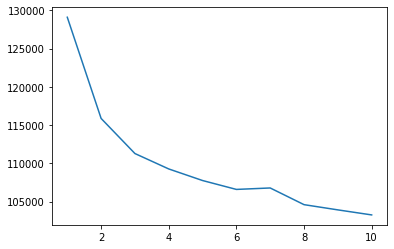

In [23]:
x = list(range(1,11))
y = []
for i in x:
    model = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    model.fit(X.T)
    y.append(model.inertia_)

import matplotlib.pyplot as plt

plt.plot(x,y,label='linear')
plt.show();

In [16]:
trl2=[[
"personally felt","character enjoy","plot make sense","sense episode","personality even","enough screen time","kind game","series addictive","leave lasting impression","character mostly","favorite scene","average series","game really think","rave review","suspense action","play huge","premise character","easy kill","good script","far plot","cast wonderful","predictable sometimes","good storytelling","hearted people","feeling series","beautiful set","character development well","good excite","cool story","background score"],

[
"brother run","tug war game","cup tea","korean hunger","nature show","blue danube","japanese game","chef's kiss","alice borderland hunger","korean drama always","train busan zombie","archer girl","battle royale alice","piggy bank","classical music","renew second season","never read webtoon","find food water","school violence","lord fly","moon jo's","hunger game maze","move building","sewol ferry","western actor","detective kang","best kdramas","taxi driver","organ harvest","political drama"],

[
"apocalyptic show","brutality game","monster roam","pure evil","show monster","lot people die","school violence","mutate monster","lady vengeance","drama everyone","attack titan","big fan horror","away horror","lose entire family","protein monster","game parasite","vip awful","anti capitalist","martial law","asian horror","fantasy horror","spoil anything","gratuitous violence","gory scene","never read webtoon","human desperation","devil judge","crazy lady","bad netflix","murder torture"],

[
"faith humanity","drama friendship","chef's kiss","sweet home south","english dialogue","love asian","sang wook","find food water","copy cat","read comic","kind game","comedic relief","take breath","love actor","hard know trust","sunshine goblin","everyone love","wrap completely","blue danube","predictable sometimes","hearted people","well write act","hype train","really understand people","fit scene","save brother","great job character","hand best","best kdramas","family friend"],

[
"hook story","genre find","special effect story","get hooked","drama squid","actor story","play mysterious","character twist","story humanity","premise character","engage show","dimensional character","scene light","catch guard","flesh character","men mask","try drama","interest story","flaw series","character flashback","bore enjoy","study human","act storyline","scene drag","steal show","aspect series","edge seat show","needle say","contain spoiler best","plot character development"],

[
"really enjoy drama","thrilling emotional","cast wonderful","drama perfect","character enjoy","drama deserve","good storytelling","story great acting","good script","cool story","good graphic","human scary","power hungry","series addictive","favorite scene","even funny","drama however","hearted people","many annoy","drama mixed","nerve wrack","good action drama","leave lasting impression","creepy smile","overrate drama","plot make sense","dynamic character","gratuitous violence","suspense action","love drama much"]]

In [ ]:
trl2